# GHG emissions of global countries in a given year (in a treemap)

This infographic is based on a dataset from [EDGAR](https://edgar.jrc.ec.europa.eu/emissions_data_and_maps). This version specifically (emissions in 2023) is based on the [Global Greenhouse Gas Emissions dataset, version 2024](https://edgar.jrc.ec.europa.eu/dataset_ghg2024) (section "Annual totals by sector and country (1970-2023)", item "EDGAR Total GHG in CO2eq").


In [132]:
import os
import sys

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../"))

In [133]:
from IPython.display import Markdown, display
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify
import numpy as np

from data_analysis.edgar_geo import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *

## Parameters

In [134]:
YEAR = 2023

# Don't convert svg texts to curves.
plt.rcParams['svg.fonttype'] = 'none'

## Fetch the data from EDGAR

In [135]:
edgar_ghg_path = '../../data/edgar/v8.0/EDGAR_AR5_GHG_1970_2023.xlsx'

edgar_cols = {
    'C_group_IM24_sh': 'geo',
    'Country_code_A3': 'code',
    'Name': 'country',
    f'Y_{YEAR}': 'emissions'
}

edgar = pd.read_excel(edgar_ghg_path, sheet_name='TOTALS BY COUNTRY', header=9)
edgar = edgar[list(edgar_cols)].rename(columns=edgar_cols)

# Do not exclude international shipping and aviation
# edgar = edgar[~edgar['code'].isin(['SEA', 'AIR'])]

In [136]:
edgar.head()


,geo,code,country,emissions
0,Rest Central America,ABW,Aruba,561.497605
1,India +,AFG,Afghanistan,29460.052110
2,Southern_Africa,AGO,Angola,67700.756248
3,Rest Central America,AIA,Anguilla,26.210752
4,Int. Aviation,AIR,Int. Aviation,498178.114415


In [137]:
edgar['geo'].unique()


array(['Rest Central America', 'India +', 'Southern_Africa',
       'Int. Aviation', 'Central Europe', 'Middle_East',
       'Rest South America', 'Russia +', 'Oceania', 'OECD_Europe',
       'Eastern_Africa', 'Western_Africa', 'Ukraine +', 'Brazil',
       'Southeastern Asia', 'Canada', 'China +', 'Northern_Africa',
       'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Mexico',
       'Int. Shipping', 'USA', 'Turkey'], dtype=object)

## Import global population data from UN

In [138]:
un_population_path = '../../data/un/WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx'
un_cols = {
    'ISO3 Alpha-code': 'code',
    'Year': 'year',
    'Total Population, as of 1 July (thousands)': 'population'
}

un_pop = pd.read_excel(un_population_path, sheet_name='Estimates', header=16)
un_pop = un_pop[list(un_cols)].rename(columns=un_cols)
un_pop = un_pop.dropna().loc[un_pop['year'] == YEAR]
un_pop.head()

,code,year,population
2667,BDI,2023.0,13689.45
2741,COM,2023.0,850.387
2815,DJI,2023.0,1152.944
2889,ERI,2023.0,3470.39
2963,ETH,2023.0,128691.692


In [139]:
un_pop['population'] = un_pop['population'].apply(lambda x: x*1000)
un_pop = un_pop.drop('year', axis=1)
un_pop.head()

,code,population
2667,BDI,13689450.0
2741,COM,850387.0
2815,DJI,1152944.0
2889,ERI,3470390.0
2963,ETH,128691692.0


## Merge data from UN and EDGAR to get population-based emission stats

In [140]:
emissions = pd.merge(edgar, un_pop, on='code')
emissions

,geo,code,country,emissions,population
0,Rest Central America,ABW,Aruba,561.497605,107939.0
1,India +,AFG,Afghanistan,29460.052110,41454761.0
2,Southern_Africa,AGO,Angola,67700.756248,36749906.0
3,Rest Central America,AIA,Anguilla,26.210752,14410.0
4,Central Europe,ALB,Albania,7673.671533,2811655.0
...,...,...,...,...,...
214,Oceania,WSM,Samoa,646.143595,216663.0
215,Middle_East,YEM,Yemen,32242.871779,39390799.0
216,Southern_Africa,ZAF,South Africa,522115.491123,63212384.0
217,Southern_Africa,ZMB,Zambia,30484.449374,20723965.0


Group countries in their geographical regions

In [142]:
geo_map = {
    'Africa': ['Southern_Africa', 'Eastern_Africa', 'Western_Africa', 'Northern_Africa'],
    'Europe': ['Central Europe', 'OECD_Europe', 'Ukraine +'],
    'Russia': ['Russia +'],
    'Asia': ['India +', 'Middle_East', 'Southeastern Asia', 'China +', 'Indonesia +', 'Japan', 'Asia-Stan', 'Korea', 'Turkey'],
    'NAmerica': ['Canada', 'USA', 'Mexico'],
    'SCAmerica': ['Rest Central America', 'Rest South America', 'Brazil'],
    'Oceania': ['Oceania']
}

geo_map_flat = {y: x for x in geo_map for y in geo_map[x]}

eu_sum = emissions.loc[emissions['geo'].isin(geo_map['Europe'])].sum()
africa_sum = emissions.loc[emissions['geo'].isin(geo_map['Africa'])].sum()
asia_sum = emissions.loc[emissions['geo'].isin(geo_map['Asia'])].sum()
na_sum = emissions.loc[emissions['geo'].isin(geo_map['NAmerica'])].sum()
sca_sum = emissions.loc[emissions['geo'].isin(geo_map['SCAmerica'])].sum()
oce_sum = emissions.loc[emissions['geo'].isin(geo_map['Oceania'])].sum()

emissions['geo_group'] = emissions['geo'].map(geo_map_flat)
emissions

,geo,code,country,emissions,population,geo_group
0,Rest Central America,ABW,Aruba,561.497605,107939.0,SCAmerica
1,India +,AFG,Afghanistan,29460.052110,41454761.0,Asia
2,Southern_Africa,AGO,Angola,67700.756248,36749906.0,Africa
3,Rest Central America,AIA,Anguilla,26.210752,14410.0,SCAmerica
4,Central Europe,ALB,Albania,7673.671533,2811655.0,Europe
...,...,...,...,...,...,...
214,Oceania,WSM,Samoa,646.143595,216663.0,Oceania
215,Middle_East,YEM,Yemen,32242.871779,39390799.0,Asia
216,Southern_Africa,ZAF,South Africa,522115.491123,63212384.0,Africa
217,Southern_Africa,ZMB,Zambia,30484.449374,20723965.0,Africa


Aggregate geographical groups 

In [55]:
default_topology_params = {
    "include_geo_groups": [],
    "include_codes": [],
    "exclude_codes": [],
    "subset_of": "",
}

geo_topology = {
    "Europe": {
        "include_geo_groups": ["Europe"],
    },
    "RUS": {
        "include_geo_groups": ["Russia"],
    },
    "Asia": {
        "include_geo_groups": ["Asia"],
    },
    "Africa": {
        "include_geo_groups": ["Africa"],
    },
    "NAmerica": {
        "include_geo_groups": ["NAmerica"],
    },
    "SCAmerica": {
        "include_geo_groups": ["SCAmerica"],
    },
    "Oceania": {
        "include_geo_groups": ["Oceania"],
    },
    "Europe w/o Russia, EU": {
        "include_geo_groups": ["Europe"],
        "exclude_codes": [e.value for e in EU],
        "subset_of": "Europe",
    },
    "EU": {
        "include_codes": [e.value for e in EU],
        "subset_of": "Europe",
    },
    "Asia w/o China, India": {
        "include_geo_groups": ["Asia"],
        "exclude_codes": ["CHN", "IND"],
        "subset_of": "Asia",
    },
    "CHN": {
        "include_codes": ["CHN"],
        "subset_of": "Asia",
    },
    "IND": {
        "include_codes": ["IND"],
        "subset_of": "Asia",
    },
    "USA": {
        "include_codes": ["USA"],
        "subset_of": "NAmerica",
    },
    "NAmerica w/o USA": {
        "include_geo_groups": ["NAmerica"],
        "exclude_codes": ["USA"],
        "subset_of": "NAmerica",
    },
}


We are translating the topology because the names in it correspond closely to the names in the emission table keys that will be created later.

In [144]:
# Add the root dir to the path, so we can load the module.
import os
import sys
from pathlib import Path

sys.path.append(os.path.abspath("../../"))

from data_analysis.localization import Translator
translator = Translator('../../loc', locale='cs')

geo_topology = {
    translator.translate_country(name):
        default_topology_params | entry | {
            "subset_of": translator.translate_country(entry.get("subset_of", ""))
        }
    for name, entry in geo_topology.items()
}


In [145]:
def create_geo_aggregations(df, arr):
    # name, include_geo_groups, include_codes, exclude_codes
    geo_group_emissions = []
    for name, entry in arr.items():
        geo_group_emissions.append([
            name,
            df.loc[df['geo_group'].isin(entry['include_geo_groups'])]['emissions'].sum()
                + df.loc[df['code'].isin(entry['include_codes'])]['emissions'].sum()
                - df.loc[df['code'].isin(entry['exclude_codes'])]['emissions'].sum(),
            df.loc[emissions['geo_group'].isin(entry['include_geo_groups'])]['population'].sum()
                + df.loc[df['code'].isin(entry['include_codes'])]['population'].sum()
                - df.loc[df['code'].isin(entry['exclude_codes'])]['population'].sum()
        ])
    columns = ['id', 'emissions', 'population']
    geo_group_emissions_df = pd.DataFrame(geo_group_emissions, columns=columns)
    return geo_group_emissions_df

geo_group_emissions = create_geo_aggregations(
    emissions,
    geo_topology
)

geo_group_emissions


,id,emissions,population
0,Evropa,4.069213e+06,5.920110e+08
1,Rusko,2.764475e+06,1.625096e+08
2,Asie,3.073336e+07,4.764571e+09
3,Afrika,3.198420e+06,1.469287e+09
4,Severní Amerika,7.420631e+06,5.125219e+08
5,Jižní a Střední Amerika,2.790416e+06,5.289198e+08
6,Oceánie,6.717002e+05,3.517315e+07
7,"Evropa mimo Rusko, EU",8.474189e+05,1.413535e+08
8,EU-27,3.221795e+06,4.506575e+08
9,"Asie mimo Číny, Indie",1.065581e+07,1.903916e+09


Run calculations for per-capita and percentage ghg emissions

In [146]:
total_emissions=geo_group_emissions['emissions'].sum()
geo_group_emissions['em_per_capita'] = (geo_group_emissions['emissions'] * 1000) / geo_group_emissions['population']
geo_group_emissions['em_per_cent'] = (geo_group_emissions['emissions'] * 100) / total_emissions
geo_group_emissions['emissions_summary'] = \
    geo_group_emissions['emissions'].apply(czech_float) + \
    " (" + geo_group_emissions['em_per_cent'].apply(czech_float) + "%)"
geo_group_emissions.sort_values('emissions', ascending=False, inplace=True)
geo_group_emissions


,id,emissions,population,em_per_capita,em_per_cent,emissions_summary
2,Asie,3.073336e+07,4.764571e+09,6.450393,32.739846,"30 733 355,0 (32,7%)"
10,Čína,1.594399e+07,1.422585e+09,11.207757,16.984923,"15 943 986,6 (17,0%)"
9,"Asie mimo Číny, Indie",1.065581e+07,1.903916e+09,5.596787,11.351501,"10 655 814,1 (11,4%)"
4,Severní Amerika,7.420631e+06,5.125219e+08,14.478662,7.905102,"7 420 631,1 (7,9%)"
12,Spojené státy,5.960804e+06,3.434773e+08,17.354287,6.349968,"5 960 804,4 (6,3%)"
11,Indie,4.133554e+06,1.438070e+09,2.874377,4.403422,"4 133 554,4 (4,4%)"
0,Evropa,4.069213e+06,5.920110e+08,6.873544,4.334880,"4 069 213,5 (4,3%)"
8,EU-27,3.221795e+06,4.506575e+08,7.149098,3.432136,"3 221 794,6 (3,4%)"
3,Afrika,3.198420e+06,1.469287e+09,2.176852,3.407236,"3 198 420,5 (3,4%)"
5,Jižní a Střední Amerika,2.790416e+06,5.289198e+08,5.275688,2.972594,"2 790 415,8 (3,0%)"


## Plot the graphs

In this section, the prepared dataset is used for two subgraphs

### Code for creating the subgraphs

In [147]:
def _draw_treemap_plot(year, df, geo_topology):
    cmap = matplotlib.cm.viridis
    mini = min(df['emissions'])
    maxi = max(df['emissions'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df['emissions']]

    # Make the figure a bit larger to accommodate a complex graph.
    fig = plt.figure()
    ax = fig.add_axes(rect=(0, 0, 1, 1))

    def normalize(parent, norm_x, norm_y, norm_dx, norm_dy, ordered_ids):
        curr_level_names = [
            name for name, entry in geo_topology.items() if entry['subset_of'] == parent
        ]
        curr_level_items = df.loc[df['id'].isin(curr_level_names)]['id'].to_numpy().tolist()
        sizes = df.loc[df['id'].isin(curr_level_items)]['emissions']
        normed = squarify.normalize_sizes(sizes, norm_dx, norm_dy)
        rects = squarify.squarify(normed, norm_x, norm_y, norm_dx, norm_dy)
        ordered_ids += curr_level_items

        for new_parent, new_parent_rect in zip(curr_level_items, rects):
            rects += normalize(
                new_parent,
                new_parent_rect["x"],
                new_parent_rect["y"],
                new_parent_rect["dx"],
                new_parent_rect["dy"],
                ordered_ids
            )
        return rects

    ordered_ids = []
    rects = normalize("", 0, 0, 100, 100, ordered_ids)
    # Squarify puts the largest square on the bottom left. The resulting graph should have it on
    # the top left, thus flip the y-axis.
    for rect, ordered_id, color in zip(rects, ordered_ids, colors):
        # We are applying some extra padding here on each item manually instead of using the ax.bar edge line drawing.
        # This way, the area between sub-items is colored with the parent's color instead of being overwriten with the edge color.
        # This makes grouping by color clearer.
        rect["y"] = 100 - rect["y"] - rect["dy"]
        padding = 0.2
        ax.bar(rect["x"] + padding, rect["dy"] - padding,
           width=rect["dx"] - padding, bottom=rect["y"] + padding,
           color=color, label=ordered_id, align="edge")

    # Print the labels of countries and their emission summary
    pad_x = 0.5
    for l, r, c in zip(ordered_ids, rects, colors):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        if l in [name for name, entry in geo_topology.items() if entry['subset_of'] == ""]:
            pad_y_text = dy - 4
            pad_y_emissions = dy - 2
            pad_x_text = 0
            pad_x_emissions = 0

            color = c
            backgroundcolor = "white"
        else:
            pad_y_text = 1
            pad_y_emissions = 3
            pad_x_text = 0
            pad_x_emissions = 0
            color = "white"
            backgroundcolor = "black"

        ax.text(
          x + pad_x - pad_x_text, y + dy - pad_y_text, l,
          va="top", ha="left", color="white", fontsize=5, fontweight="bold",
        )
        emissions = df.loc[df['id'] == l]['emissions_summary'].item()
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(
          x + pad_x - pad_x_emissions, y + dy - pad_y_emissions, emissions, va="top",
          ha="left", color="white", fontsize=5,
        )

    plt.title(
        f"Celkové roční emise států světa za rok {year}\nv milionech tun CO2 ekv.")
    plt.axis("off")

    plt.savefig("../../outputs/emissions-treemap-global.svg")


In [148]:
def _draw_barh_plot(year, df):
    fig = plt.figure(figsize=(6, 8))
    df_sorted = \
        df.sort_values(by="em_per_capita", ascending=True).reset_index()

    real_bar = plt.barh(df_sorted.index, df_sorted["em_per_capita"], color="lightsteelblue")
    # Add per-capita emissions values to the right of the bars.
    plt.bar_label(real_bar, labels=[czech_float(x) for x in df_sorted["em_per_capita"]], padding=5, fontsize=7)

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_sorted.index, [0] * df_sorted.index.size)
    # Add country name labels inside the bar.
    plt.bar_label(fake_bar, labels=df_sorted["id"], padding=5, fontsize=7)

    plt.title(f"Roční emise na obyvatele (tuny CO2 ekv.)\nv regionech světa za rok {year}.")
    plt.axis("off")

    plt.savefig("../../outputs/emissions-bars-global.svg")


### Plot the graphs and export them as SVG

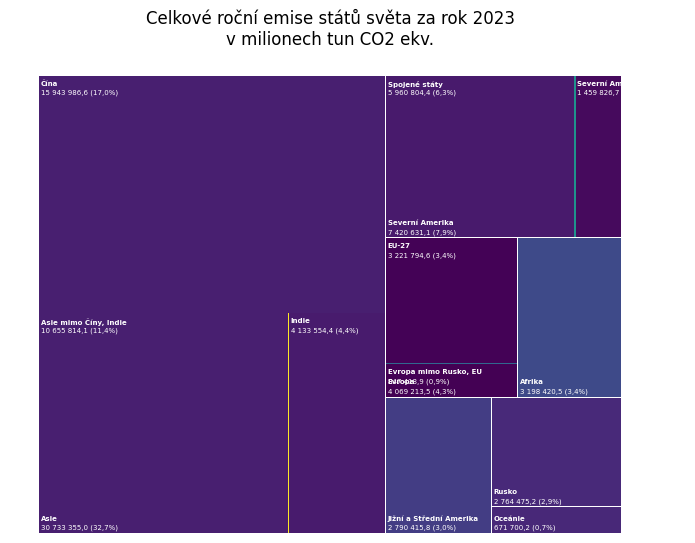

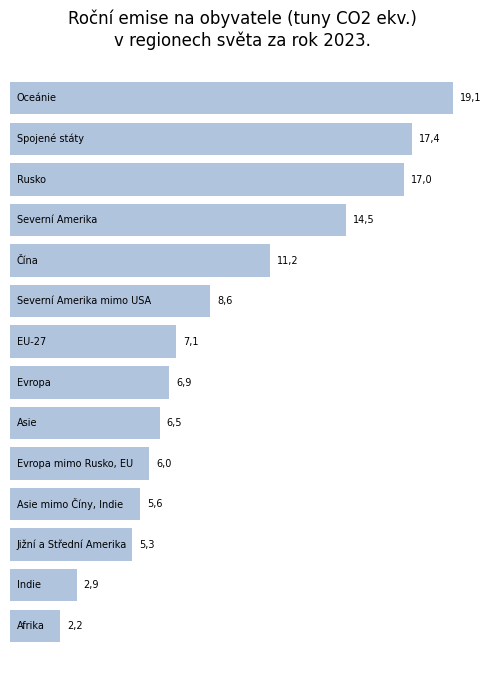

In [149]:
_draw_treemap_plot(YEAR, geo_group_emissions, geo_topology)
_draw_barh_plot(YEAR, geo_group_emissions)


## Figures for accompanying text

In this section, we calculate the figures that appear in the accompanying text to this infographic.


In [151]:
global_emissions_gtco2eq = edgar["emissions"].sum() / 1e6
global_population_mn = un_pop["population"].sum() / 1e6

cz_emissions_gtco2eq = (
  edgar[edgar["code"] == "CZE"]["emissions"].iloc[0] / 1e6
)
cz_emissions_share_pct = \
  100 * cz_emissions_gtco2eq / global_emissions_gtco2eq
cz_population_mn = \
  un_pop[un_pop["code"] == "CZE"]["population"].iloc[0] / 1e6
cz_population_share_pct = \
  100 * cz_population_mn / global_population_mn
cz_emissions_intensity_ktco2eq_per_cap = \
  cz_emissions_gtco2eq / cz_population_mn

global_emissions_cz_counterfactual_gtco2eq = \
  cz_emissions_intensity_ktco2eq_per_cap * global_population_mn

asia_emissions_gtco2eq = \
  geo_group_emissions[geo_group_emissions["id"] == "Asie"]["emissions"].iloc[0] / 1e6
asia_population_mn = \
  geo_group_emissions[geo_group_emissions["id"] == "Asie"]["population"].iloc[0] / 1e6
asia_population_share_pct = \
  100 * asia_population_mn / global_population_mn

global_emissions_asia_counterfactual_gtco2eq = \
  asia_emissions_gtco2eq / asia_population_mn * global_population_mn

display(Markdown(f"""
- Total global emissions in {YEAR}: **{global_emissions_gtco2eq:.1f} Gt CO₂eq**
- CZ emissions in {YEAR}: **{cz_emissions_gtco2eq:.3f} Gt CO₂eq** = {cz_emissions_share_pct:.2f} % of global
- CZ population in {YEAR}: {cz_population_mn:.1f} million = {cz_population_share_pct:.2f} % of global
- Global emissions if everybody became Czech: {global_emissions_cz_counterfactual_gtco2eq:.1f} GtCO₂eq
- Asia emissions in {YEAR}: {asia_emissions_gtco2eq:.1f} Gt CO₂eq
- Asia population in {YEAR}: {asia_population_mn:.1f} million = {asia_population_share_pct:.1f} % of global
- Global emissions if everybody became Asian: {global_emissions_asia_counterfactual_gtco2eq:.1f} GtCO₂eq
"""))



- Total global emissions in 2023: **53.0 Gt CO₂eq**
- CZ emissions in 2023: **0.114 Gt CO₂eq** = 0.22 % of global
- CZ population in 2023: 10.8 million = 0.13 % of global
- Global emissions if everybody became Czech: 85.7 GtCO₂eq
- Asia emissions in 2023: 30.7 Gt CO₂eq
- Asia population in 2023: 4764.6 million = 58.9 % of global
- Global emissions if everybody became Asian: 52.2 GtCO₂eq
